## Final summary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium
import matplotlib
from pyspark.sql.functions import date_format
from pyspark.sql import SparkSession, functions as F
import seaborn as sns

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZon", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/07 13:59:03 WARN Utils: Your hostname, MacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.66 instead (on interface en0)
22/10/07 13:59:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 13:59:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### ETL

- The following ETL script downloads the external SA2 datasets and the covid 
data using URLs and then cleans and preprocesses them.
- Next, the script cleans and preprocesses the internal dataset and then merges
it with the external dataset.
- The script prepares a final dataset which is further used throughout the 
analysis to build a ranking model for the merchants.

In [2]:
%run "../scripts/ETL.py" '../scripts/paths.json'

/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


22/10/07 13:59:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


22/10/07 14:00:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Outlier Analysis

The following dataset is the full internal + external dataset merged together. 

In [3]:
# Show the first five rows of the complete dataset
final_join3.limit(5)

+--------------------+------------+--------------------+---------+--------------+--------------------+--------------------+-----+------+------------------+------------------+--------------------+--------------+-------+-----------+-------+---------+----------+----------+---------+---------+-------------------+----------------+-----------+-------------+-------------+----------+---------------+---------------+---------------+--------------------------+--------------------------+
|       merchant_name|merchant_abn|          categories|take_rate|revenue_levels|                name|             address|state|gender|trans_merchant_abn|      dollar_value|            order_id|order_datetime|user_id|consumer_id| suburb|postcodes|      long|       lat|  int_sa2| SA2_code|           SA2_name|income_2018-2019|total_males|total_females|total_persons|state_code|     state_name|population_2020|population_2021|fraud_probability_consumer|fraud_probability_merchant|
+--------------------+------------+--------------------+---------+--------------+--------------------+--------------------+-----+------+------------------+------------------+--------------------+--------------+-------+-----------+-------+---------+----------+----------+---------+---------+-------------------+----------------+-----------+-------------+-------------+----------+---------------+---------------+---------------+--------------------------+--------------------------+
|Egestas Nunc Asso...| 11121775571|digital goods: bo...|     6.58|             a|Christopher Rodri...|30554 Evans Strea...|  NSW|  Male|       11121775571| 11.28829564583802|2bd2a61d-72e5-42d...|    2021-08-20|   3698|       1175|JESMOND|     2299|151.704581|-32.909816|111031231|111031231|Shortland - Jesmond|       242936885|       6412|         6179|        12593|         1|New South Wales|          12598|          12694|                      0.01|                      0.01|
|Morbi Accumsan In...| 19618998054|tent and aWning s...|     1.52|             c|Christopher Rodri...|30554 Evans Strea...|  NSW|  Male|       19618998054| 62.90176609196828|3582b1f8-4577-403...|    2021-05-16|   3698|       1175|JESMOND|     2299|151.704581|-32.909816|111031231|111031231|Shortland - Jesmond|       242936885|       6412|         6179|        12593|         1|New South Wales|          12598|          12694|                      0.01|                      0.01|
| Eu Dolor Egestas PC| 94472466107|cable, satellite,...|     6.23|             a|Christopher Rodri...|30554 Evans Strea...|  NSW|  Male|       94472466107|172.15375126873164|cb05d49f-c2fa-453...|    2021-07-22|   3698|       1175|JESMOND|     2299|151.704581|-32.909816|111031231|111031231|Shortland - Jesmond|       242936885|       6412|         6179|        12593|         1|New South Wales|          12598|          12694|                      0.01|                      0.01|
|Urna Justo Indust...| 31472801314|music shops - mus...|     6.56|             a|Christopher Rodri...|30554 Evans Strea...|  NSW|  Male|       31472801314|0.4894787650356477|aeec15c1-67e8-4cb...|    2021-05-18|   3698|       1175|JESMOND|     2299|151.704581|-32.909816|111031231|111031231|Shortland - Jesmond|       242936885|       6412|         6179|        12593|         1|New South Wales|          12598|          12694|                      0.01|                      0.01|
|Eu Sem Pellentesq...| 35424691626|computers, comput...|      3.9|             b|Christopher Rodri...|30554 Evans Strea...|  NSW|  Male|       35424691626| 7.360217018778133|9df473ba-102d-461...|    2021-07-04|   3698|       1175|JESMOND|     2299|151.704581|-32.909816|111031231|111031231|Shortland - Jesmond|       242936885|       6412|         6179|        12593|         1|New South Wales|          12598|          12694|                      0.01|                      0.01|
+--------------------+------------+--------------------+---------+--------------+--------------------+--------------------+-----+------+----------------

- The outlier script removes the outliers from the above complete dataset in the 
following ways:
    - Removes values with null merchant abn
    - Removes instances with transactions with a dollar value of 0 or less 
    0
    - Removes values with null customer id
    - Remove instances where gender is null

In [4]:

%run "../scripts/outlier.py" '../scripts/paths.json'

22/10/07 14:01:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
df.head()

Outlier removal  Count after outlier removal
0              Original count                     10540321
1          Valid Merchant ABN                     10109371
2    Transactions with non $0                     10109371
3           Valid customer ID                     10109371
4  Non null values for gender                     10109371

As seen above, null values were only present in the merchant abn column which
were removed to prepare the final dataset

### Visualise internal data

22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:35 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/07 14:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:26:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:40 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:45 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:27:56 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:03 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/07 14:28:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/07 14:28:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


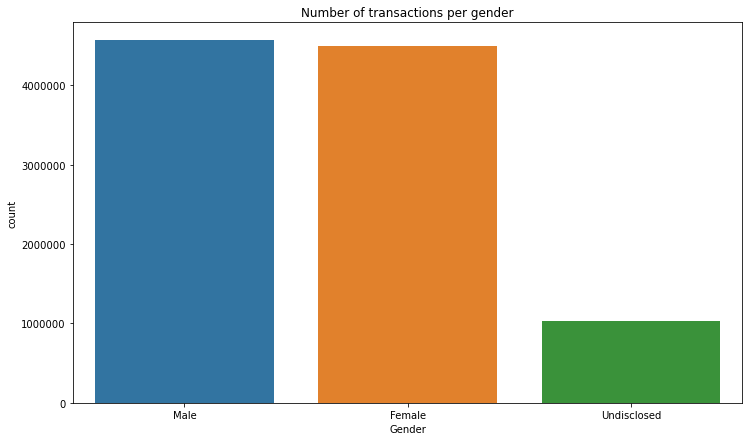

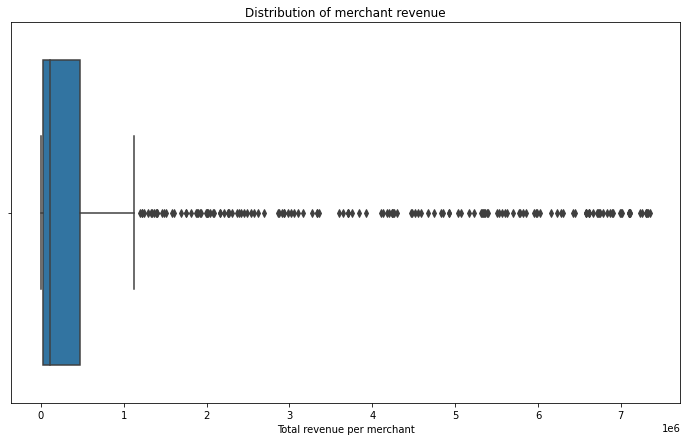

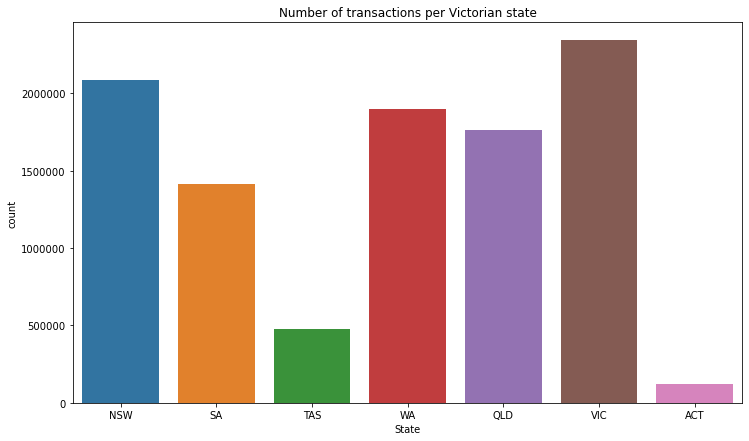

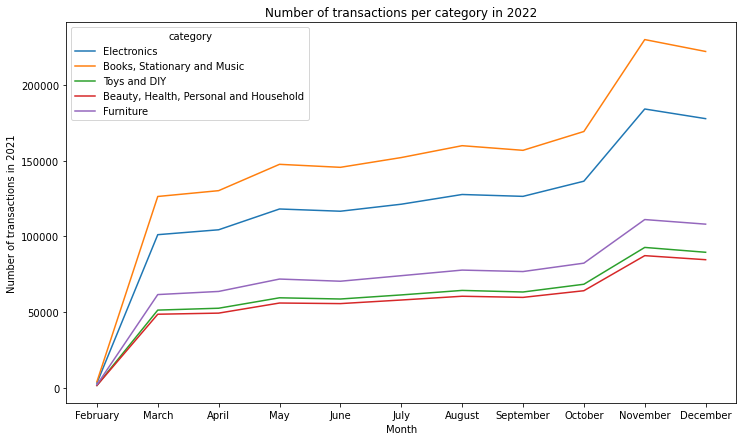

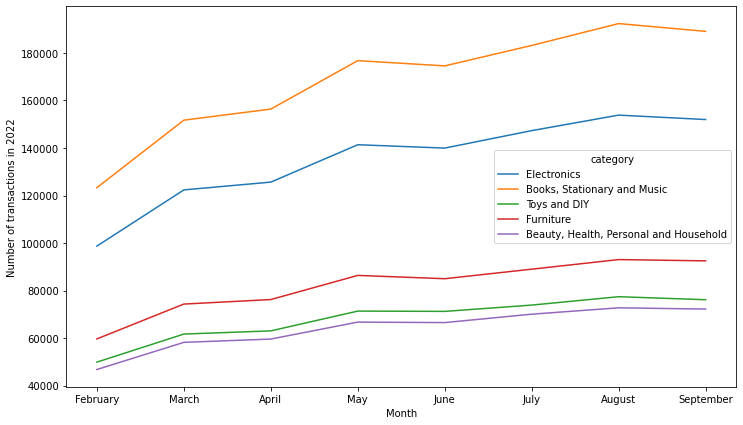

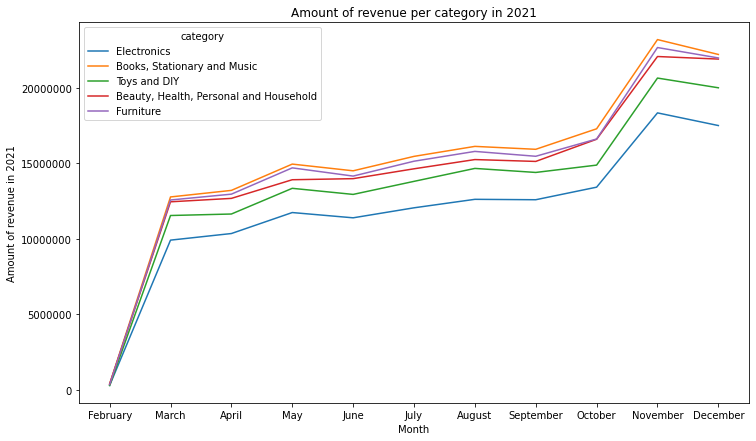

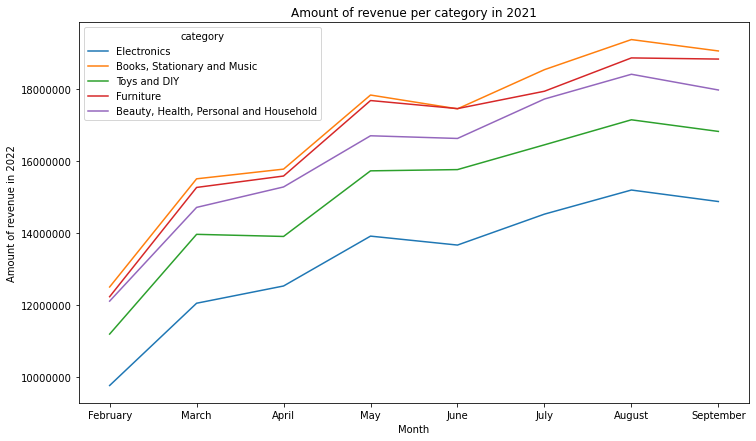

In [14]:
%run "../scripts/visualizations.py" '../scripts/paths.json'
m

### External datasets - Outliers

Summary statistics for the Census data - 


           SA2_code   total_males  total_females  total_persons
count  2.472000e+03   2472.000000    2472.000000    2472.000000
mean   3.177555e+08   5074.887136    5209.415049   10284.254450
std    1.977886e+08   3019.275754    3161.883118    6171.395057
min    1.010210e+08      0.000000       0.000000       0.000000
25%    1.270315e+08   2669.750000    2678.000000    5384.750000
50%    3.030411e+08   4774.000000    4875.000000    9656.000000
75%    4.060111e+08   7169.000000    7511.500000   14675.000000
max    9.999995e+08  14327.000000   13783.000000   28116.000000


Summary statistics for the Income data - 


    SA2_code           SA2_name  income_2018-2019
0  101021007          Braidwood         120763285
1  101021008            Karabar         338308979
2  101021009         Queanbeyan         441160946
3  101021010  Queanbeyan - East         237035656
4  101021011  Queanbeyan Region        1050285692


Summary statistics for the Incom

[]


Summary statistics for the Population data - 


    SA2_code                         SA2_name  state_code       state_name  \
0  101021007                        Braidwood           1  New South Wales   
1  101021008                          Karabar           1  New South Wales   
2  101021009                       Queanbeyan           1  New South Wales   
3  101021010                Queanbeyan - East           1  New South Wales   
4  101021012  Queanbeyan West - Jerrabomberra           1  New South Wales   

   population_2020  population_2021  
0             4273             4330  
1             8519             8546  
2            11437            11370  
3             5077             5093  
4            12796            12743  


Summary statistics for the population in 2020 per SA2 code data - 


count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Nam

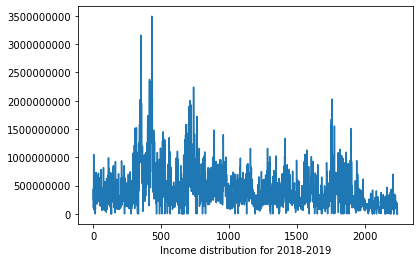

In [7]:
%run "../scripts/outlier_external.py" '../scripts/paths.json'

# Tags to categories


In [10]:
%run "../scripts/NLP.py" '../scripts/paths.json'

THE TOP 15 WORDS FOR TOPIC #0
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC #1
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC #2
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC #3
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS FOR TOPIC #4
['television', 'radio', 'cable', 'satellite', 'pay', 'equipment', 'computer', 'software', 'peripheral', 'computers', 'novelty', 'card', 'gift', 'souvenir', 'shops']




In [11]:
merchants_df.head(5)

name  \
0                         Felis Limited   
1              Arcu Ac Orci Corporation   
2                      Nunc Sed Company   
3  Ultricies Dignissim Lacus Foundation   
4                   Enim Condimentum PC   

                                                tags  merchant_abn  \
0  ((furniture, home furnishings and equipment sh...   10023283211   
1  ([cable, satellite, and otHer pay television a...   10142254217   
2  ([jewelry, watch, clock, and silverware shops]...   10165489824   
3  ([wAtch, clock, and jewelry repair shops], [b]...   10187291046   
4  ([music shops - musical instruments, pianos, a...   10192359162   

                                        cleaned_tags  store_type  \
0  furniture home furnishings and equipment shops...           0   
1  cable satellite and other pay television and r...           4   
2           jewelry watch clock and silverware shops           1   
3               watch clock and jewelry repair shops           1   
4  music shops  musical instruments pianos and sh...           3   

                      category  
0                    Furniture  
1                  Electronics  
2                 Toys and DIY  
3                 Toys and DIY  
4  Books, Stationary and Music

### Ranking models 

In [7]:
# Run all the models to get the features for the ranking model
%run "../models/Revenue_model.py" '../scripts/paths.json'
  

22/10/07 15:45:49 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB


22/10/07 15:45:50 WARN DAGScheduler: Broadcasting large task binary with size 1435.6 KiB


22/10/07 15:45:52 WARN DAGScheduler: Broadcasting large task binary with size 1439.6 KiB


22/10/07 15:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1552.2 KiB


22/10/07 15:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1614.0 KiB


22/10/07 15:46:04 WARN DAGScheduler: Broadcasting large task binary with size 1734.9 KiB


22/10/07 15:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1965.9 KiB


22/10/07 15:46:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/10/07 15:47:41 WARN DAGScheduler: Broadcasting large task binary with size 1450.2 KiB


+-----------------+------------------+--------------------+
|       prediction|             label|            features|
+-----------------+------------------+--------------------+
|282.5032142059864| 175.5058926208255|(2085,[209,1093,2...|
|301.1446138928202| 184.5112457341748|(2085,[209,988,20...|
|301.1446138928202| 273.6255392020826|(2085,[209,976,20...|
|314.1304217160475| 421.7745544721037|(2085,[209,989,20...|
|298.8577897215912|152.81812360693857|(2085,[209,1039,2...|
+-----------------+------------------+--------------------+
only showing top 5 rows



22/10/07 15:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1440.8 KiB


22/10/07 15:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1441.9 KiB


22/10/07 15:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1440.8 KiB


22/10/07 15:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1441.9 KiB


In [2]:
%run "../models/BNPL_earning_model.py" '../scripts/paths.json'


22/10/07 14:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/10/07 14:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1433.1 KiB


22/10/07 14:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1437.1 KiB


22/10/07 14:52:59 WARN DAGScheduler: Broadcasting large task binary with size 1549.7 KiB


22/10/07 14:53:14 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB


22/10/07 14:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1732.2 KiB


22/10/07 14:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1971.2 KiB


22/10/07 14:53:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/10/07 14:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


22/10/07 14:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1439.9 KiB


22/10/07 15:02:12 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


22/10/07 15:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1439.9 KiB


In [9]:
%run "../models/Customers_model.py" '../scripts/paths.json'


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):                                              
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2727, in safe_execfile
    py3compat.execfile(
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/IPython/utils/py3compat.py", line 55, in execfile
    exec(compiler(f.read(), fname, "exec"), glob, loc)
  File "/Users/Kasturi/Documents/GitHub/generic-buy-now-pay-later-project-group-10-bnpl/scripts/Customers_model.py", line 312, in <module>
    model = rf.fit(trainingData)
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/pyspark/ml/wrapper.py", line 379, in _fit
    java_model = self._fit_java(dataset)
  File "/Users/Kasturi/opt/anaconda3/lib/python3.9/site-packages/pyspark/ml/wrapper.py", line 376, in _fit_java
    return self._java_obj.fit(da

In [1]:
%run "../scripts/Transactions_model.py" 

22/10/07 16:29:27 WARN Utils: Your hostname, MacBook-Air-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.66 instead (on interface en0)
22/10/07 16:29:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 16:29:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
%run "../scripts/Fraud_feature.py" '../scripts/paths.json'

In [ ]:


# take list of values as weights for fraud, transactions, revenue, customer, take rate
%run '../models/ranking_model.py' 4,2,1,3,5